In [55]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math

MEASURE_SEPARATOR = "|--|"
LINE_SEPARATOR = "\n------------------\n"
FAILED_MEASUREMENT = "*"
POPULARITY_POSITION = 0
COUNTER_INITIAL_VALUE = 0
HOST_POSITION = 1
COUNTRY_POSITION = 2
LATENCY_POSITION = 3
TRACEROUTE_POSITION = 4
BYTES_GRABBED_POSITION = 5
LAST_IDX = -1
BAD_OUTPUT = -1
LATENCY_PREFIX = "time "
LATENCY_UNITS = "ms"
LATENCY_UNITS_WITH_SPACING_OFFSET = " ms"
SPACING_OFFSET = " "
OFF_BY_ONE_OFFSET = 1
NEWLINE = "\n"
DEGREE_FIT_FOR_LINEAR_RELATIONSHIPS = 1

# we want to parse the data such that we extract relevant metrics appropriately
class dataParser:
    # give this a file name in the local path (or path to open) for grabbing extracted data
    def __init__(self, dataPath):
        self.dataPath = dataPath
        
    # This is the main function used to grab all relevant data
    def getMetrics(self):
        # all the metrics we care about keeping track of
        popularity = []
        websites = []
        countries = []
        latencies = []
        routeLengths = []
        routeLatencies = []
        bytesGrabbed = []
        
        for chunk in self.getFileChunks():
            # each chunks components
            measures = self.chunkComponents(chunk)
            
            # minimal processing required here, grab information as is
            popularity.append(int(measures[POPULARITY_POSITION]))
            websites.append(measures[HOST_POSITION])
            countries.append(measures[COUNTRY_POSITION])
            bytesGrabbed.append(int(measures[BYTES_GRABBED_POSITION][:LAST_IDX]))
            
            # some processing needed - more complex string manipulations called for these
            latency = self.extractLatency(measures[LATENCY_POSITION])
            latencies.append(latency)
            
            routeLength = self.extractRouteLength(measures[TRACEROUTE_POSITION])
            routeLengths.append(routeLength)
            
            routeLatency = self.extractRouteTimes(measures[TRACEROUTE_POSITION])
            routeLatencies.append(routeLatency)

        return (popularity, websites, countries, latencies, routeLengths, routeLatencies, bytesGrabbed)
    
    # This is a helper to do string manipulation required to grab latency
    def extractLatency(self, latencyString):
        timeIdx = latencyString.index(LATENCY_PREFIX)
        timeEndIdx = latencyString.index(LATENCY_UNITS)
        if timeIdx > LAST_IDX:
            return float(latencyString[timeIdx + len(LATENCY_PREFIX):timeEndIdx])    
        return BAD_OUTPUT
    
    # this is a helper for string manipulation that gets you the route length
    def extractRouteLength(self, routeLengthString):
        return routeLengthString.count(NEWLINE) - OFF_BY_ONE_OFFSET
    
    # this is a helper for the string manipulation that gets you the various times along the network traceroute
    def extractRouteTimes(self, routesString):
        # this gets us set up to ignore the first line of a traceroute output (which is just telling us we are using traceroute)
        routeTimes = []
        firstNewlineIdx = routesString.index(NEWLINE) + len(NEWLINE)
        routeLines = routesString[firstNewlineIdx:LAST_IDX].split(NEWLINE)
        
        # now look through each route timing line
        for route in routeLines:
            # if we did not fail the measurement, look for the bit that specifies timing in ms
            if route[-1] != FAILED_MEASUREMENT:
                timingMarker = route.rfind(LATENCY_UNITS_WITH_SPACING_OFFSET)
                routeWithoutTimingMarker = route[:timingMarker]
                timeMarker = routeWithoutTimingMarker.rfind(SPACING_OFFSET) + len(SPACING_OFFSET)
                routeTimes.append(float(route[timeMarker:timingMarker]))
            # if we failed the measurement then just use the last valid route time - we can assume that it holds just as a contingency
            else:
                routeTimes.append(routeTimes[LAST_IDX]) # we assume for routes that are not reported, the route time was identical to the last recorded route time
        return routeTimes
    
    # simple helper method to grab the separate components of each chunk (each measurement set we take)
    # this includes (popularity, hostname, country, ping_out, traceroute_out, curl_out)
    def chunkComponents(self, chunk):
        return chunk.split(MEASURE_SEPARATOR)
    
    # grab each chunk (measurement set we take) from the file
    def getFileChunks(self):
        file = self.fileAsText()
        splitFile = file.split(LINE_SEPARATOR)
        return splitFile[:LAST_IDX] # remove the last lineSeparator of the file
    
    # helper to open a simple text file and output its contents
    def fileAsText(self):
        with open(self.dataPath, 'r') as file:
            fileContents = file.read()
            return fileContents

# now separately from parsing through data, we would like to analyze it all
# this involves making plots, as well as particular statistical measurements
class analyzeData:
    # on init we just save all the metrics from a parsed file into separate self._xyz_ arrays for future reference
    def __init__(self, metrics):
        (self.popularity,
        self.websites,
        self.countries,
        self.latencies,
        self.routeLengths,
        self.routeLatencies,
        self.bytesGrabbed) = metrics
    
    # this looks at (plots and statistically analyzes) network latency to different countries
    def analyzeNetworkLatencyToCountries(self):
        # make some arrays so that we can average out these latencies by country appropriately
        latenciesOverCountries = {}
        countriesCount = {}
        countriesSpecificData = {}
        
        # first we just grab and organize the latency data
        for latency, country in zip(self.latencies, self.countries):
            # and if we have observed a country add to its total
            if country in latenciesOverCountries.keys():
                latenciesOverCountries[country] += latency
                countriesCount[country] += 1
                countriesSpecificData[country].append(latency)
            # otherwise define the first value we observe for that country
            else:
                latenciesOverCountries[country] = latency
                countriesCount[country] = 1
                countriesSpecificData[country] = [latency]
        
        # now we figure out the deviation in latencies by country
        # and we also convert the sum into a mean
        deviationInLatencies = []
        for country, latency in latenciesOverCountries.items():
            total = latenciesOverCountries[country]
            latenciesOverCountries[country] = total/countriesCount[country] # sum to mean
            # if we can get the deviation then good
            try:
                deviationInLatencies.append(statistics.stdev(countriesSpecificData[country]))
            # otherwise something went wrong - just throw in a zero (assume no deviation for bad measurements)
            except:
                deviationInLatencies.append(COUNTER_INITIAL_VALUE)
            # give the user some output for the deviation
            print(str(country) + " has standard deviation in latency : " + str(deviationInLatencies[-1]))
            
        # and this is just some standard code to make a bar graph plot with standard deviation represented
        plt.bar(latenciesOverCountries.keys(), latenciesOverCountries.values(), yerr=deviationInLatencies, capsize=10)
        plt.xlabel("Countries")
        plt.ylabel("Average Latencies")
        plt.title("Latency Vs Country")
        plt.show()
    
    # this looks at network latency for various route lengths through the network
    def analyzeNetworkLatencyByRouteLength(self):
        # we are scattering x = route length
        # we are scattering y = latency
        plt.scatter(self.routeLengths, self.latencies)
        plt.xlabel("Route Lengths")
        plt.ylabel("Latencies")
        plt.title("Latency Vs Route Lengths through the network")
        
        #include a line of best fit (line of best fit should be linear here)
        slope, intercept = np.polyfit(self.routeLengths, self.latencies, deg=DEGREE_FIT_FOR_LINEAR_RELATIONSHIPS)
        lineOfBestFit = slope * np.array(self.routeLengths) + intercept # numpy only wants to multiply with a numpy array, so we just make one here
        
        # plot it out
        plt.plot(self.routeLengths, lineOfBestFit, label="line of best fit", color="green")
        plt.show()
        
        # additionally we should compute some basic stats regarding our scatter plot
        self.statsHelper(self.routeLengths, self.latencies, "Route Lengths", "Latencies")
    
    # now we want to look at how latency changes along a route - in which part (beginning, first 1/2, second 1/2, or end) - is network latency larger/smaller? and how?
    def analyzeLatenciesAlongRoutes(self):
        # so define arrays for that
        beginning, firstMiddle, secondMiddle, end = [], [], [], []
        
        # for each latency we grabbed from traceroute
        for latencyList in self.routeLatencies:
            # take the raw beginning and raw ending values
            beginning.append(latencyList[COUNTER_INITIAL_VALUE])
            end.append(latencyList[LAST_IDX])
            
            # account for lists where the length is not >= 4 (where grabbing first and second halves becomes more complicated)
            if len(latencyList) < 4:
                # give the first half the same value as beginning by default (in cases of 2, 3 this works pretty nicely)
                firstMiddle.append(latencyList[COUNTER_INITIAL_VALUE])
                if len(latencyList) < 3:
                    secondMiddle.append(latencyList[LAST_IDX]) # if two values then just assign the second half the same value as end
                else:
                    secondMiddle.append(latencyList[COUNTER_INITIAL_VALUE + OFF_BY_ONE_OFFSET]) # else give it the middle value
                continue
            
            # if we have length >= 4
            # first 1/2 is given as the average of the [first beginning++ : first 1/2] of data
            # and second 1/2 is given as the average of the [first 1/2 ++ : end--] of data
            firstHalfIdx = int(math.floor(len(latencyList)/(OFF_BY_ONE_OFFSET + OFF_BY_ONE_OFFSET)))
            firstSection = latencyList[1:firstHalfIdx]
            secondSection = latencyList[firstHalfIdx + OFF_BY_ONE_OFFSET : LAST_IDX]
            firstMiddle.append(sum(firstSection)/len(firstSection))
            secondMiddle.append(sum(secondSection)/len(secondSection))
        
        # print the stats for beginning, first 1/2, second 1/2, and end (we just look at median and variance here) over all the traceroute measurements
        print("Beginning : Median = " + str(statistics.median(beginning)) + " : Variance = " + str(statistics.stdev(beginning)))
        print("FirstMiddle : Median = " + str(statistics.median(firstMiddle)) + " : Variance = " + str(statistics.stdev(firstMiddle)))
        print("SecondMiddle : Median = " + str(statistics.median(secondMiddle)) + " : Variance = " + str(statistics.stdev(secondMiddle)))
        print("End : Median = " + str(statistics.median(end)) + " : Variance = " + str(statistics.stdev(end)))
        
        # and a box plot can represent this nicely
        plt.boxplot([beginning, firstMiddle, secondMiddle, end])
        plt.xlabel("Beginning | First Portion of Middle | Second Portion of Middle | End")
        plt.ylabel("Latencies along Network path")
        plt.title("Latency Along Network Paths")
        plt.show()
        
    # Now consider how popularity of a website impacts latency to it
    def analyzeLatencyAlongPopularity(self):
        # this is a simple stats + scatterplot scenario
        # the good news is that we basically have all the formatting we really need done
        plt.scatter(self.popularity, self.latencies)
        plt.xlabel("Popularity (Descending Order)")
        plt.ylabel("Latency")
        plt.title("Latency Considering Website Popularity")
        plt.show()
        
        self.statsHelper(self.popularity, self.latencies, "Popularity Rating", "Latencies", modeX=False)
        
    # Lastly lets consider download size and its impact on latency
    def analyzeDownloadSizeAndLatency(self):
        # so to do that we just want to take an average of latencies for various bytes downloaded
        latenciesForBytes = {}
        countforBytes = {}
        for bytes, latency in zip(self.bytesGrabbed, self.latencies):
            if bytes in latenciesForBytes.keys():
                latenciesForBytes[bytes] += latency
                countforBytes[bytes] += 1.0
            else:
                latenciesForBytes[bytes] = latency
                countforBytes[bytes] = 1.0
        
        # average that out here (sum to average)
        for bytes, latency in latenciesForBytes.items():
            latenciesForBytes[bytes] /= countforBytes[bytes]
        
        # now build ourselves a scatterplot
        plt.scatter(latenciesForBytes.keys(), latenciesForBytes.values())
        plt.xlabel("Bytes Downloaded")
        plt.ylabel("Latency")
        plt.title("Download Size's Impact on Latency")
        plt.show()
        
        # and grab some useful stats
        self.statsHelper(self.bytesGrabbed, self.latencies, "Downloaded Bytes", "Latencies")
    
    # this is a helper method designed to do a whole bunch of statistical measurements and print the results
    # all you do is provide the x value array, y value array, and the names you are giving to X, Y respectively
    # if you want to disable a measurement being printed just set the optional parameter for that measurement to False
    # Otherwise you will get by default: Correlation, Standard Deviation, Mode for X values, Mode for Y Values, Covariance, Median of Y values
    def statsHelper(self, xarray, yarray, xname, yname, correlation=True, stdev=True, modeX=True, modeY=True, covariance=True, median=True):
        stddev = statistics.stdev(xarray)
        correlation = statistics.correlation(xarray, yarray)
        covariance = statistics.covariance(xarray, yarray)
        modeX = statistics.mode(xarray)
        modeY = statistics.mode(yarray)
        median = statistics.median(yarray)
        if correlation: print("Correlation Between " + xname + " and " + str(yname) + " : " + str(correlation))
        if stdev: print("Standard Deviation for "  + xname + " vs " + str(yname) + " : " + str(stddev))
        if modeX: print("Most Typical " + xname + " : " + str(modeX))
        if modeY: print("Most Typical " + yname + " : " + str(modeY))
        if covariance: print("Covariance of Variables : " + str(covariance))
        if median: print("Median " + yname + " : " + str(median))

In [56]:
# set up the parser here
parser = dataParser('data.txt')
m = parser.getMetrics()
analyzer = analyzeData(m)

United States has standard deviation in latency : 2.1213203435596424
Australia has standard deviation in latency : 0


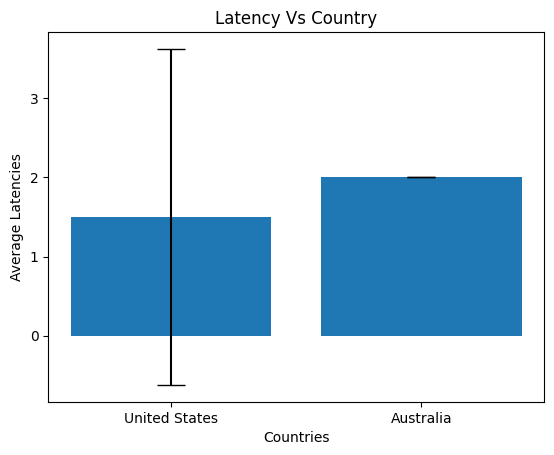

In [57]:
# first insight
analyzer.analyzeNetworkLatencyToCountries()

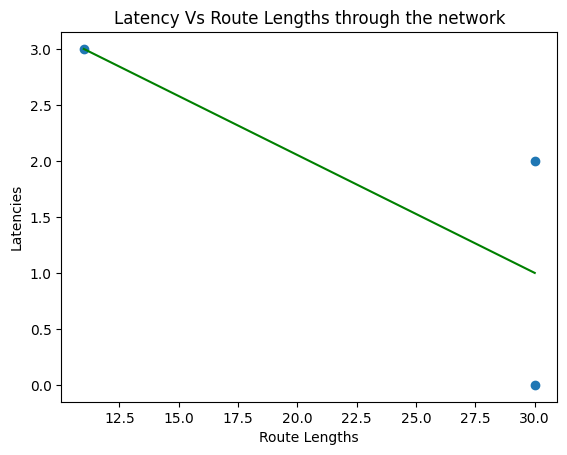

Correlation Between Route Lengths and Latencies : -0.7559289460184544
Standard Deviation for Route Lengths vs Latencies : 10.96965511460289
Most Typical Route Lengths : 30
Most Typical Latencies : 3.0
Covariance of Variables : -12.666666666666666
Median Latencies : 2.0


In [58]:
# second insight
analyzer.analyzeNetworkLatencyByRouteLength()

Beginning : Median = 0.852 : Variance = 0.3355756248597327
FirstMiddle : Median = 106.155 : Variance = 37.20252230684765
SecondMiddle : Median = 130.7805 : Variance = 25.598022014189972
End : Median = 117.504 : Variance = 52.33481671889182


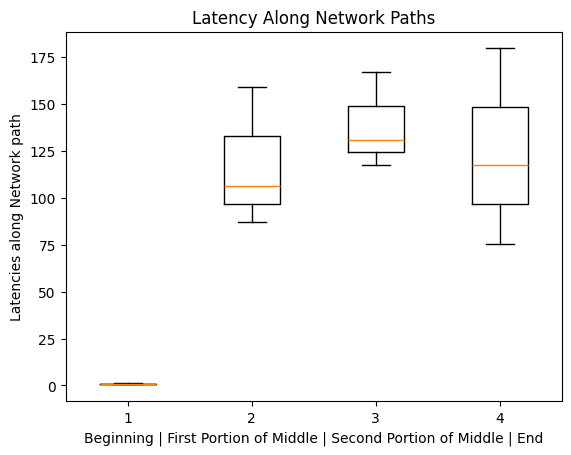

In [59]:
# third insight
analyzer.analyzeLatenciesAlongRoutes()

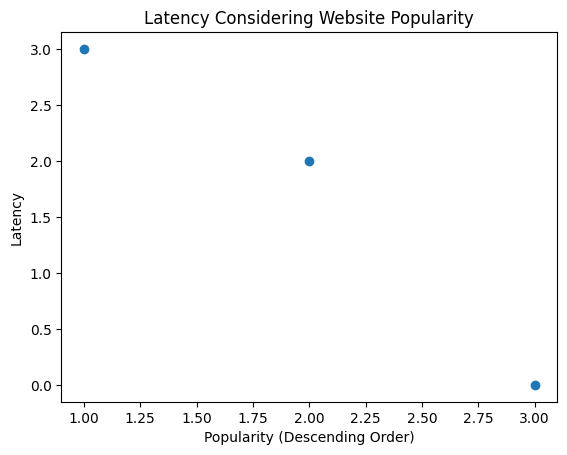

Correlation Between Popularity Rating and Latencies : -0.9819805060619656
Standard Deviation for Popularity Rating vs Latencies : 1.0
Most Typical Popularity Rating : 1
Most Typical Latencies : 3.0
Covariance of Variables : -1.5
Median Latencies : 2.0


In [60]:
# fourth insight
analyzer.analyzeLatencyAlongPopularity()

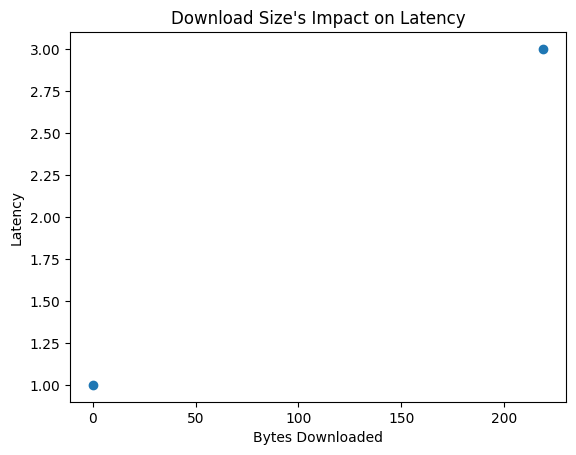

Correlation Between Downloaded Bytes and Latencies : 0.7559289460184544
Standard Deviation for Downloaded Bytes vs Latencies : 126.43970895252804
Most Typical Latencies : 3.0
Covariance of Variables : 146.0
Median Latencies : 2.0


In [61]:
# fifth insight
analyzer.analyzeDownloadSizeAndLatency()